# Starting point
## Maximum tidal amplitude compared against TPXO 7.2 solution
What I try do achive is a comparison of maximum tidal amplitude from ROMS against the TPXO7.2 solution (provides forcing for ROMS). To do so, I compare ROMS maximum sea surface height anomaly from a hourly record of 14 days against the summation of the amplitudes over all (8) constituents from the forcing file. 

In [1]:
# load roms history output as Xarray dataset
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np

file_path = os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','ocean_his_hourly.nc')
ds_ref = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
#roms_ref_ampl_max = ds_ref.zeta.max('ocean_time')-ds_ref.zeta.mean('ocean_time')

In [2]:
# load tpxo forcing amplitude and phase information as Xarray dataset
tpxo_path = os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_tds_large.nc')
dsf = xr.open_mfdataset(tpxo_path)

# calculate the superposition of amplitudes of all constituents (max tidal amplitude possible)
#tpxo_ampl_max = dsf.sum('tide_period')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


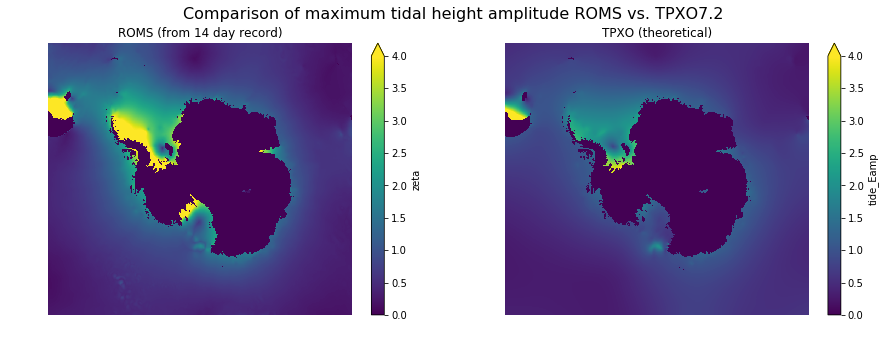

In [4]:
# plot both next to each other with same colorbounds
plt.clf()
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,5))
fig.suptitle('Comparison of maximum tidal height amplitude ROMS vs. TPXO7.2',fontsize=16)
roms_ref_ampl_max.fillna(0).plot(ax=ax1,vmax=4)
ax1.set_title('ROMS (from 14 day record)')
ax1.axis('off')
tpxo_ampl_max.tide_Eamp.plot(ax=ax2,vmax=4)
ax2.set_title('TPXO (theoretical)')
ax2.axis('off')
plt.show()

... Roms gets about two times to high under the big ice shelves. Since the height looks ok everywhere else, this might be related to the kelvin waves. Two ideas to fix this:
1. no forcing on the continental shelf
2. increase bottom/ice shelf drag, high resolution might help

## Comparison of M2 and O1 amplitude maps
(others violate Rayleigh condition with just 14 day record) 
Apply t_tide tidal harmonic analysis on every grid point and fill O1 and M2 amplitude maps in Xarray dataset.
First define the function

In [3]:
import ttide as tt
import numpy as np
import pandas as pd
from scipy.interpolate import NearestNDInterpolator
import sys
import os

# add the 'src/visualization/' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)

# import my methods, make sure they get reloded by each call
from visualization.log_progress import log_progress

def NDinterp(data):

    valid_mask = ~np.isnan(data)
    coords = np.array(np.nonzero(valid_mask)).T
    values = data[valid_mask]

    it = NearestNDInterpolator(coords,values)

    filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

    return filled    


def O1_M2_ampl(ds,grid_ds,res):
    
    print('setting up the new fields')
    dummy = np.empty((ds.eta_rho.size,ds.xi_rho.size))
    dummy[:,:] = np.nan
    
    ds['O1_ampl']=(('eta_rho','xi_rho'),dummy.copy())
    ds['M2_ampl']=(('eta_rho','xi_rho'),dummy.copy())
    
    #stime = datetime(1996,12,31,1)
    stime = pd.to_datetime(ds.ocean_time[0].values)
    
    
    print("applying t_tide")
    xi_values = np.linspace(0,ds.xi_rho.size-1,res,dtype=int,endpoint=True)
    eta_values = np.linspace(0,ds.eta_rho.size-1,res,dtype=int,endpoint=True)
    
    for xi in log_progress(xi_values,name='xi'):
        #print('processing xi: ',xi)
        for eta in eta_values:

            ds_sl = ds.isel(eta_rho=eta,xi_rho=xi)

            if ds_sl.zeta.isnull().values.any():
                ds.O1_ampl[eta,xi] = np.NaN
                ds.M2_ampl[eta,xi] = np.NaN
            else:
                signal = ds_sl.zeta.values
                latitude = ds_sl.lat_rho.values
                try:
                    ttide_out = tt.t_tide(signal,stime=stime,lat=latitude,out_style=None)

                    ind_O1 = list(ttide_out['nameu']).index(b'O1  ')
                    ind_M2 = list(ttide_out['nameu']).index(b'M2  ')

                    O1_ampl = ttide_out['tidecon'][ind_O1][0]
                    M2_ampl = ttide_out['tidecon'][ind_M2][0]

                    ds.O1_ampl[eta,xi] = O1_ampl
                    ds.M2_ampl[eta,xi] = M2_ampl

                except TypeError:

                    ds.O1_ampl[eta,xi] = np.NaN
                    ds.M2_ampl[eta,xi] = np.NaN
                    
    print('interpolating the remaining cells and mask land')
    for con in ['O1_ampl','M2_ampl']:
        ds[con].values = NDinterp(ds[con].values)
        ds[con] = ds[con].where(grid_ds.mask_rho,0.0) 
      
        
    return ds

attempt do include parallel processing, but its actually slower!

In [4]:
import ttide as tt
import numpy as np
import pandas as pd
from joblib import parallel, delayed
from scipy.interpolate import NearestNDInterpolator

def O1_M2_ampl(ds,res):
    

    print('setting up the new fields')
    dummy = np.empty((ds.eta_rho.size,ds.xi_rho.size))
    dummy[:,:] = np.nan
    
    ds['O1_ampl']=(('eta_rho','xi_rho'),dummy)
    ds['M2_ampl']=(('eta_rho','xi_rho'),dummy)
    
    print("applying t_tide")
    xi_values = np.linspace(0,ds.xi_rho.size-1,res,dtype=int,endpoint=True)
    eta_values = np.linspace(0,ds.eta_rho.size-1,res,dtype=int,endpoint=True)
    
    result = Parallel(n_jobs=1,verbose=0)(delayed(ttide_grid)(ds,xi,eta) for xi in xi_values for eta in eta_values)
    
    for xi,eta,O1,M2 in result:
        ds.O1_ampl[eta,xi] = O1
        ds.M2_ampl[eta,xi] = M2
        
    print('interpolating the remaining cells and mask land')
    for con in ['O1_ampl','M2_ampl']:
        ds[con].values = NDinterp(ds[con].values)
        ds[con] = ds[con].where(ds.mask_rho,0.0)
    
    return ds


def NDinterp(data):

    valid_mask = ~np.isnan(data)
    coords = np.array(np.nonzero(valid_mask)).T
    values = data[valid_mask]

    it = NearestNDInterpolator(coords,values)

    filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

    return filled    

def ttide_grid(ds,xi,eta):
    
    ds_sl = ds.isel(eta_rho=eta,xi_rho=xi)

    if ds_sl.zeta.isnull().values.any():
        O1_ampl = np.NaN
        M2_ampl = np.NaN
    else:
        stime = pd.to_datetime(ds.ocean_time[0].values)
        signal = ds_sl.zeta.values
        latitude = ds_sl.lat_rho.values
        try:
            ttide_out = tt.t_tide(signal,stime=stime,lat=latitude,out_style=None)

            ind_O1 = list(ttide_out['nameu']).index(b'O1  ')
            ind_M2 = list(ttide_out['nameu']).index(b'M2  ')

            O1_ampl = ttide_out['tidecon'][ind_O1][0]
            M2_ampl = ttide_out['tidecon'][ind_M2][0]

        except TypeError:

            O1_ampl = np.NaN
            M2_ampl = np.NaN
                    
    return xi,eta,O1_ampl,M2_ampl

then apply to dataset.

In [4]:
grid_lr_path =  os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_grd_large.nc')
grid_lr = xr.open_mfdataset(grid_lr_path)
ds_ref = O1_M2_ampl(ds_ref,grid_lr,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


Plot against TPXO O1 and M2 amplitude maps

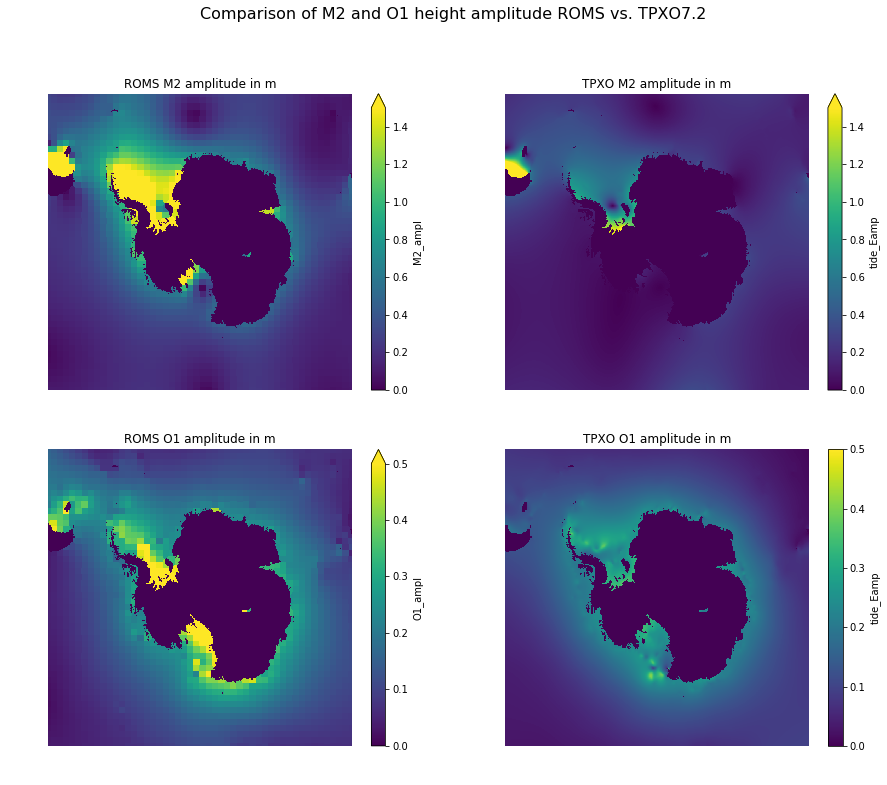

In [5]:
plt.close('all')
fig,axes = plt.subplots(2,2,figsize=(15,12))
ax1,ax2,ax3,ax4 = axes.flatten()
fig.suptitle('Comparison of M2 and O1 height amplitude ROMS vs. TPXO7.2',fontsize=16)
ds_ref.M2_ampl.fillna(0).plot(ax=ax1,vmax=1.5)
ax1.set_title('ROMS M2 amplitude in m')
ax1.axis('off')
dsf.tide_Eamp[0].plot(ax=ax2,vmax=1.5)
ax2.set_title('TPXO M2 amplitude in m')
ax2.axis('off')
ds_ref.O1_ampl.fillna(0).plot(ax=ax3,vmax=0.5)
ax3.set_title('ROMS O1 amplitude in m')
ax3.axis('off')
dsf.tide_Eamp[5].plot(ax=ax4,vmax=0.5)
ax4.set_title('TPXO O1 amplitude in m')
ax4.axis('off')
plt.show()

... both are unacceptable to high.

# No forcing under the ice shelves
Dave suggested that the to high tides might come from some model amplification under the ice shelves. Therefore I look at an experiment, without tidal surface forcing where ice shelf is present.
## Generating the tidal mask

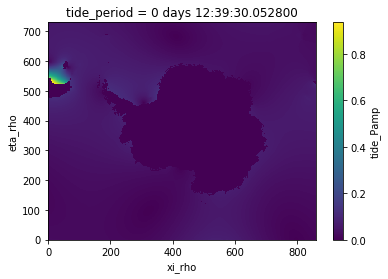

In [269]:
#mask tidal forcing
pott_path = os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_ptds_large.nc')
pott_ds = xr.open_dataset(pott_path)
grid_path =  os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_grd_large.nc')
grid_ds = xr.open_dataset(grid_path)
Pamp_masked = pott_ds.tide_Pamp.where(grid_lr.zice.values == 0.0 ,0.0)
plt.close()
Pamp_masked[2].plot()
plt.show()

## Effect on max surface height anomaly
plot against tpxo as before, but define function for later plots

In [6]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_tm_0006.nc')
ds_tm = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_tm_ampl_max = ds_tm.zeta[336:].max('ocean_time')-ds_tm.zeta[336:].mean('ocean_time')

In [5]:
import xarray as xr
import matplotlib.pyplot as plt

def plot_max_ampl(case_max_ampl_da,case_str):
    plt.clf()
    fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(17,4))
    fig.suptitle('Comparison of maximum tidal height amplitude ROMS vs. TPXO7.2',fontsize=16)
    roms_ref_ampl_max.fillna(0).plot(ax=ax1,vmax=4)
    ax1.set_title('ROMS base case')
    ax1.axis('off')
    case_max_ampl_da.fillna(0).plot(ax=ax2,vmax=4)
    ax2.set_title('ROMS '+case_str)
    ax2.axis('off')
    tpxo_ampl_max.tide_Eamp.plot(ax=ax3,vmax=4)
    ax3.set_title('TPXO (theoretical)')
    ax3.axis('off')
    plt.show()

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


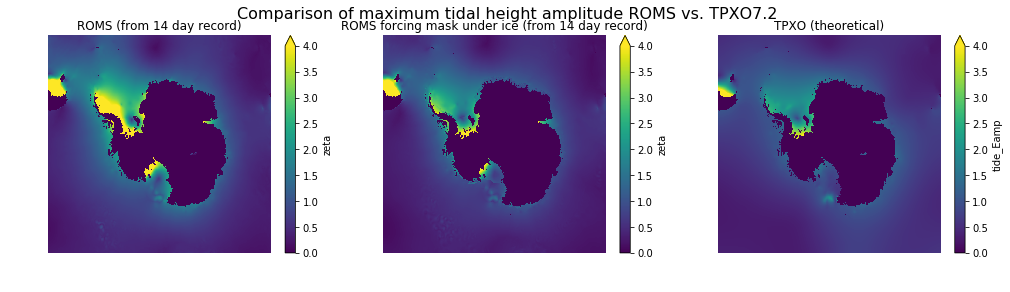

In [10]:
plot_max_ampl(roms_tm_ampl_max,'forcing mask under ice')

... this looks a lot better, though its still ssh amplitudes are still to high in the shallow areas under the ice shelves.
## M2 and O1 maps

In [7]:
ds_tm = O1_M2_ampl(ds_tm,grid_lr,20)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=20)))

KeyboardInterrupt: 

In [ ]:
# load tpxo forcing amplitude and phase information as Xarray dataset
def plot_M2O1(case_ds,case_str):
    plt.close('all')
    fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(17,8))
    ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()
    fig.suptitle('Comparison of M2 and O1 height amplitude',fontsize=16)

    ds_ref.M2_ampl.fillna(0).plot(ax=ax1,vmax=1.5)
    ax1.set_title('ROMS base case M2 amplitude in m')
    ax1.axis('off')

    case_ds.M2_ampl.fillna(0).plot(ax=ax2,vmax=1.5)
    ax2.set_title('ROMS '+ case_str +' M2 amplitude in m')
    ax2.axis('off')

    dsf.tide_Eamp[0].plot(ax=ax3,vmax=1.5)
    ax3.set_title('TPXO M2 amplitude in m')
    ax3.axis('off')


    ds_ref.O1_ampl.fillna(0).plot(ax=ax4,vmax=0.5)
    ax4.set_title('ROMS base case O1 amplitude in m')
    ax4.axis('off')

    case_ds.O1_ampl.fillna(0).plot(ax=ax5,vmax=0.5)
    ax5.set_title('ROMS '+ case_str +' O1 amplitude in m')
    ax5.axis('off')

    dsf.tide_Eamp[5].plot(ax=ax6,vmax=0.5)
    ax6.set_title('TPXO O1 amplitude in m')
    ax6.axis('off')

    plt.show()

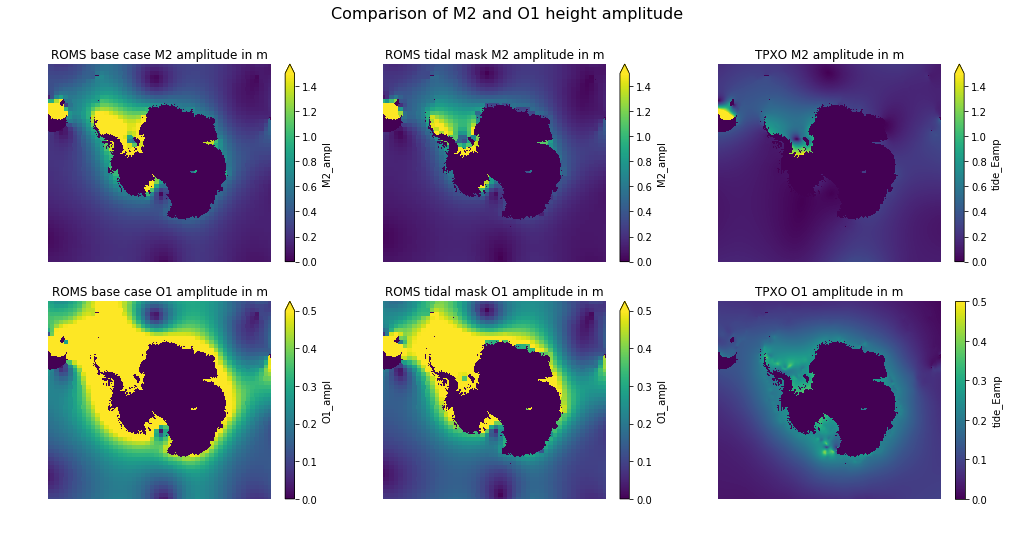

In [10]:
plot_M2O1(ds_tm,'tidal mask')

... seems like we get a big step at the mask boundary.

# 5x Drag coefficient
Ramping up the drag coefficent from 0.003 to 0.015 to represent conversion to internal tides, which is not present in 10 km model run.

In [276]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_5xCd_0006.nc')
ds_Cd = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_Cd_ampl_max = ds_Cd.zeta[336:].max('ocean_time')-ds_Cd.zeta[336:].mean('ocean_time')

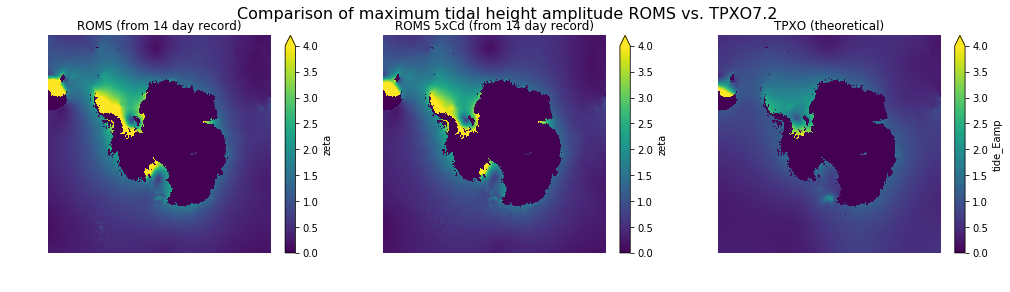

In [277]:
plot_max_ampl(roms_Cd_ampl_max,'5xCd')

... visible, but small decrease in max amplitude.
# 2x viscosity
Ramping up the visc2 from 500 m^2/s to 1000 m^2/s.

In [278]:
#look at results
import os
import xarray as xr
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_2xVisc2_0006.nc')
#file_path = '/home/ubuntu/ocean_his_2xVisc2_0006.nc'
ds_Vi = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_Vi_ampl_max = ds_Vi.zeta[336:].max('ocean_time')-ds_Vi.zeta[336:].mean('ocean_time')

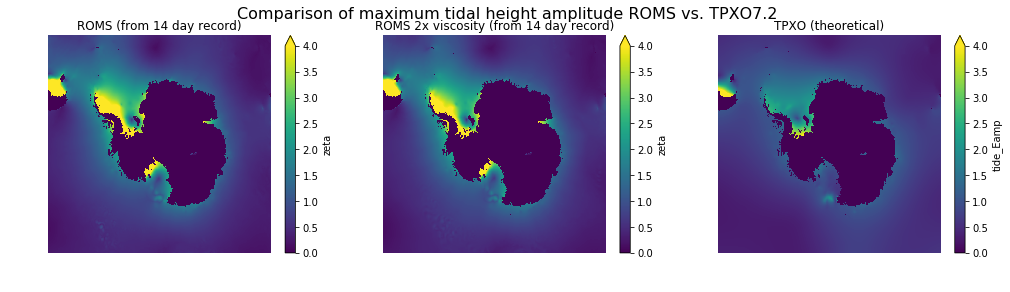

In [279]:
plot_max_ampl(roms_Vi_ampl_max,'2x viscosity')

... almost no impact.
# Mask shallow areas
Since bathymetry has such a big impact on tides, maybe our artificial deepening at the grounding lines create the bias.   
Masking shallow areas (including all artificially deepened cells) by setting mask_rho == 0 where wct <= 50 m.

In [280]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
import os
import sys
# add the 'src/visualization/' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)
from features.uvp_masks import uvp_masks
%autoreload uvp_masks

In [282]:
rmask = grid_lr.mask_rho

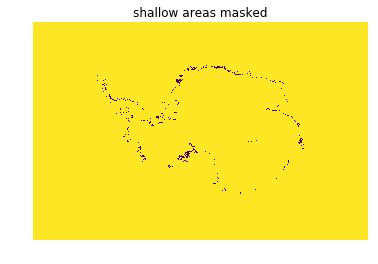

In [287]:
mask_new = rmask.where(grid_lr.h + grid_lr.zice > 50,0)
rmask_val = mask_new.values
umask,vmask,pmask = uvp_masks(rmask)
plt.close()
plt.pcolormesh(rmask_val-rmask.values)
plt.axis('off')
plt.title('shallow areas masked')
plt.show()

In [21]:
import netCDF4 as nc
out_path = '/home/ubuntu/raijin/short/m68/oxr581/waom10_tidal_mask/Data/waom10/waom10_grd_mask.nc'
id = nc.Dataset(out_path,'a')
id.variables['mask_rho'][:,:]=rmask_val
id.variables['mask_u'][:,:]= umask
id.variables['mask_v'][:,:]= vmask
id.variables['mask_psi'][:,:]= pmask
id.close()

In [288]:
#look at results
import os
import xarray as xr
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_ms_0006.nc')
ds_ms = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_ms_ampl_max = ds_ms.zeta[336:].max('ocean_time')-ds_ms.zeta[336:].mean('ocean_time')

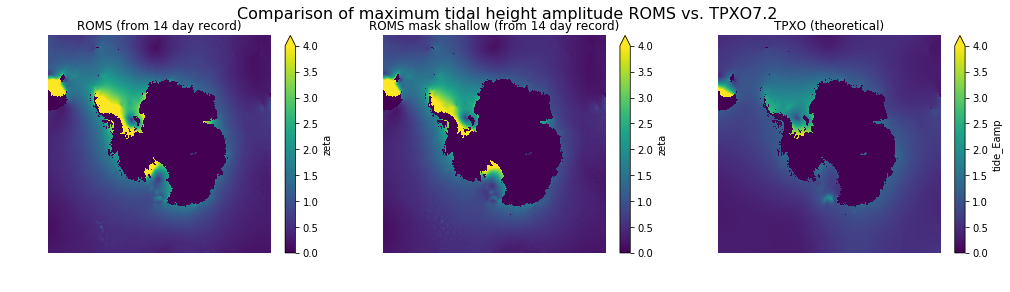

In [289]:
plot_max_ampl(roms_ms_ampl_max,'mask shallow')

... a bit better in the Weddell Sea and Amery. However in the Ross sea it seems just to shift the high amplitudes further in the direction of the kelvin wave propagation.
... more ideas would be trying a different vertical mixing scheme as recommended by Robin Robertson (MY and some GLS) and looking at the impact of increased resolution.

# 2x horizontal resolution
By increasing the horizontal resolution from 10km to 5km we hope to lose energy into baroclinic tides, which we don't resolve withthe coarse grid. Also better representation of bathymetry and ice draft, less smoothing and artificial deepening to only 30m water column thickness might have an impact. 

In [11]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom5','ocean_his_0002.nc')
ds_hr = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_hr_ampl_max = ds_hr.zeta.max('ocean_time')-ds_hr.zeta.mean('ocean_time')

### Max tidal height amplitude

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


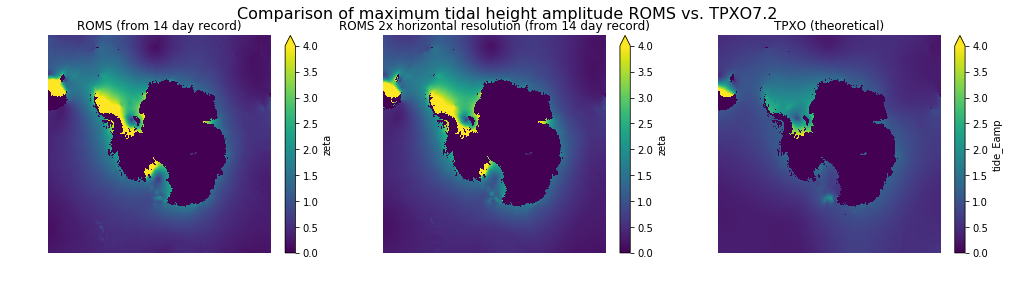

In [8]:
plot_max_ampl(roms_hr_ampl_max,'2x horizontal resolution')

### M2 O1 height amplitudes

In [12]:
ds_hr = O1_M2_ampl(ds_hr,ds_hr,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


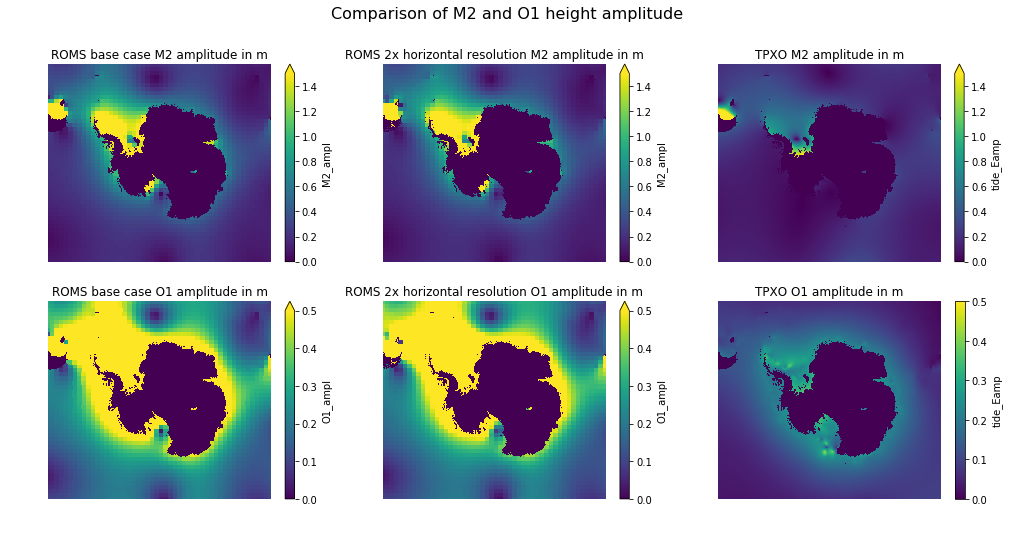

In [13]:
plot_M2O1(ds_hr,'2x horizontal resolution')

# 2x horizontal resolution and MY25 vertical mixing scheme
Following advice from Robin Roberston, I've changed the vertical mixing from LMD to MY. However, we expect MY to mix less than LMD and therefore possibly dissipate less energy?

In [14]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom5_MY','ocean_his_0002.nc')
ds_my = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_my_ampl_max = ds_my.zeta[:].max('ocean_time')-ds_my.zeta[:].mean('ocean_time')

### Max tidal height amplitude

In [15]:
# plot against tpxo as before
def plot_max_ampl_hr(case_max_ampl_da,case_str):
    plt.clf()
    fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(17,4))
    fig.suptitle('Comparison of maximum tidal height amplitude ROMS vs. TPXO7.2',fontsize=16)
    roms_hr_ampl_max.fillna(0).plot(ax=ax1,vmax=4)
    ax1.set_title('ROMS high res')
    ax1.axis('off')
    case_max_ampl_da.fillna(0).plot(ax=ax2,vmax=4)
    ax2.set_title('ROMS '+case_str)
    ax2.axis('off')
    tpxo_ampl_max.tide_Eamp.plot(ax=ax3,vmax=4)
    ax3.set_title('TPXO')
    ax3.axis('off')
    plt.show()

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


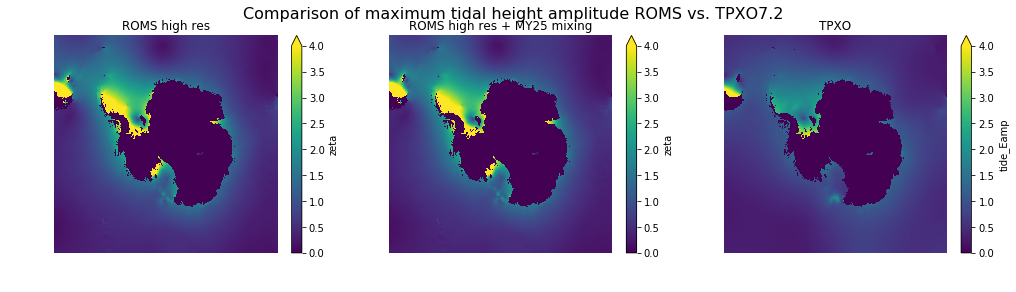

In [16]:
plot_max_ampl_hr(roms_my_ampl_max,'high res + MY25 mixing')

### M2 O1 height amplitudes

In [ ]:
ds_my = O1_M2_ampl(ds_my,ds_my,10)

In [ ]:
plot_M2O1(ds_my,'2x hr and MY25 mixing')

# 2x horizontal resolution and no topography smoothing
Following Robins papaers, I try a case, where I don't apply any smooting to the topographz (bed rock and ice draft) to enhance internal tide generation over rough topography.

In [17]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom5_rough','ocean_his_0002.nc')
ds_ns = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_ns_ampl_max = ds_ns.zeta[:].max('ocean_time')-ds_ns.zeta[:].mean('ocean_time')

### Max tidal height amplitude

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


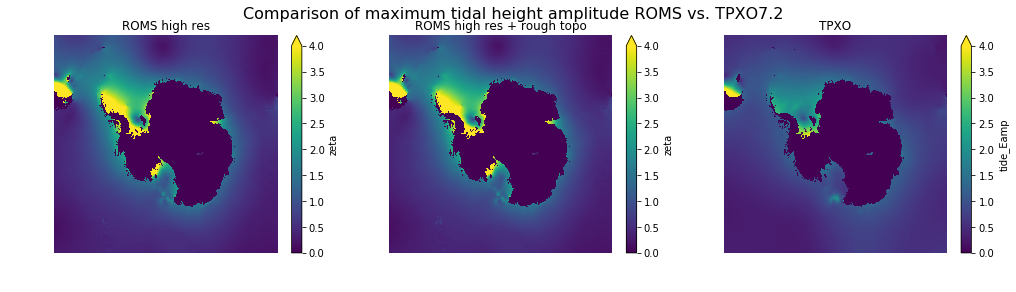

In [18]:
plot_max_ampl_hr(roms_ns_ampl_max,'high res + rough topo')

### M2 O1 height amplitudes

In [ ]:
ds_ns = O1_M2_ampl(ds_ns,ds_ns,10)

In [ ]:
plot_M2O1(ds_ns,'2x hr + rough topo')

# Scaling tidal height amplitiude of forcing
Simple solution would be to scale down the Pamp amplitude of the forcing by simply setting a scaling factor in varinfo.dat. However we have have to think about a justification for that.
To determine a rough scaling factor, I compare the ratios between roms and tpxo of sping tide amplitude, M2 and K1.

### Determining the scaling factor

In [ ]:
print('ratio of spring tide area average amplitude: ', roms_ampl_max.mean().values/tpxo_ampl_max.tide_Eamp.mean().values)
print('ratio of M2 area average amplitude: ', ds.M2_ampl.fillna(0).mean().values/dsf.tide_Eamp[0].mean().values)
print('ratio of O1 area average amplitude: ', ds.O1_ampl.fillna(0).mean().values/dsf.tide_Eamp[5].mean().values)

... so Roms spring tide is 1.55 times to big and needs to be scaled by 1/1.55 = 0.65. 

### Results:

In [19]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom5_scale','ocean_his_0002.nc')
ds_sc = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_sc_ampl_max = ds_sc.zeta[:].max('ocean_time')-ds_sc.zeta[:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


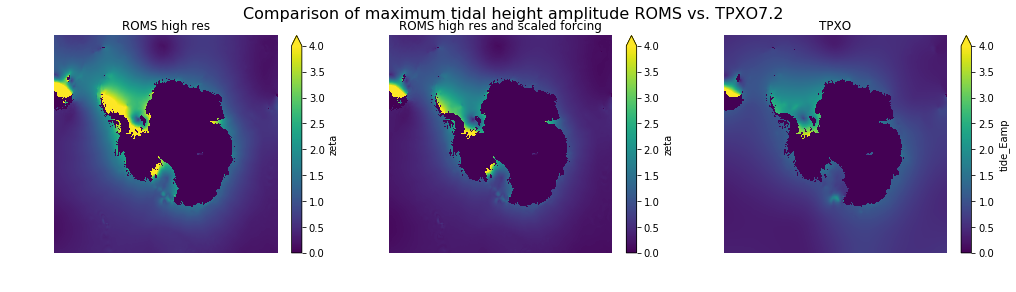

In [20]:
plot_max_ampl_hr(roms_sc_ampl_max,'high res and scaled forcing')

# Mask forcing south of 60S
Our forcing is already the reaction of a model to astronomical forcing. The kelvin waves on the shelf might be forced two times in our model. First by the deep ocean wave approaching the shelf and second by the prescribed tides on the shelf. By masking everything south of 60S and ramping full foring to 50S we hope to avoid the two sources of shelf tides.
### Generating the mask

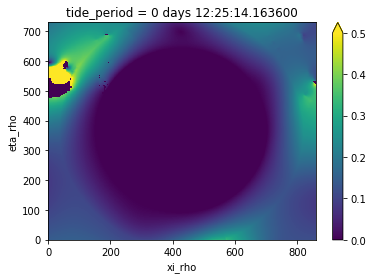

In [21]:
#mask tidal forcing
import xarray as xr
import os
import sys
import matplotlib.pyplot as plt

pott_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','Data','waom10','waom10_ptds_large.nc')
pott_ds = xr.open_dataset(pott_path)
grid_path =  os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','Data','waom10','waom10_grd_large.nc')
grid_ds = xr.open_dataset(grid_path)

Pamp_tmp = pott_ds.tide_Pamp.where(grid_ds.lat_rho > -65 ,0.0)
scale = (grid_ds.lat_rho + 65.0)/10
Pamp_masked = Pamp_tmp.where((grid_ds.lat_rho < -65)|(grid_ds.lat_rho > -55),Pamp_tmp*scale)
plt.close()
Pamp_masked[0].plot(vmax=0.5)
plt.show()

### Results

In [37]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_tm_65_0006.nc')
ds_tm_65 = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_tm_65_ampl_max = ds_tm_65.zeta[336:].max('ocean_time')-ds_tm_65.zeta[336:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


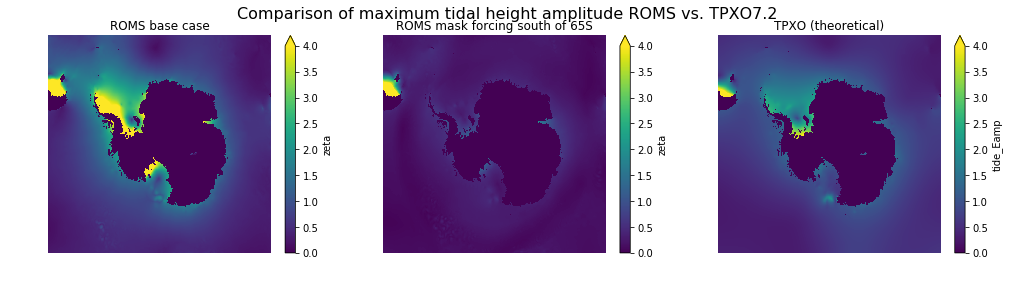

In [23]:
plot_max_ampl(roms_tm_65_ampl_max,'mask forcing south of 65S')

In [38]:
ds_tm_65 = O1_M2_ampl(ds_tm_65,ds_tm_smooth,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


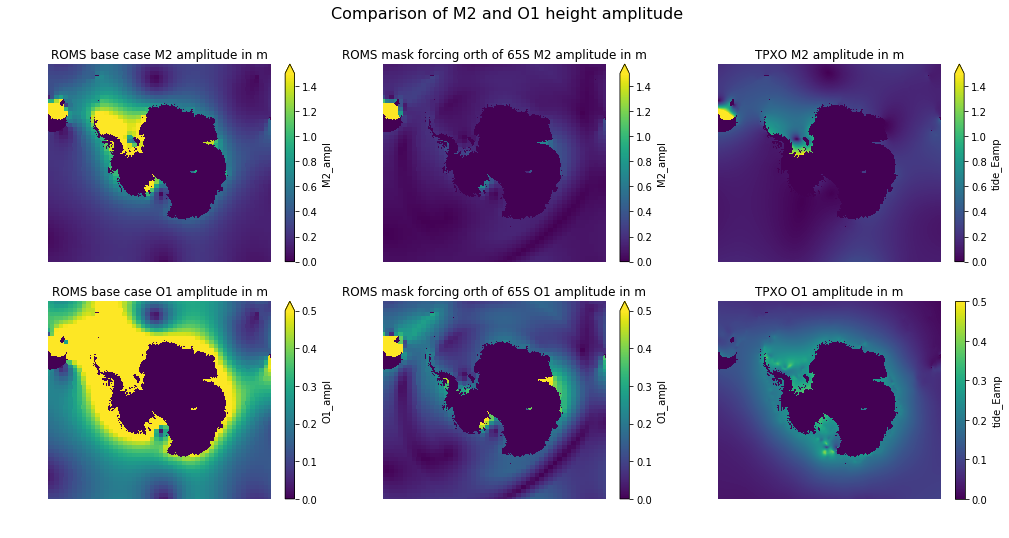

In [39]:
plot_M2O1(ds_tm_65,'mask forcing orth of 65S')

... M2 seems to be reuced big time, however O1 is still to big where the coastline is rough. Next try just masking onshelf areas with ramping to deep.

# Mask forcing on shelf
Since masking 60S is to much and masking just ice shelves is to less, I try masking the shallow areas with smooth transition.We can argue with the non linear shallow water dynamics.
### Generating the mask

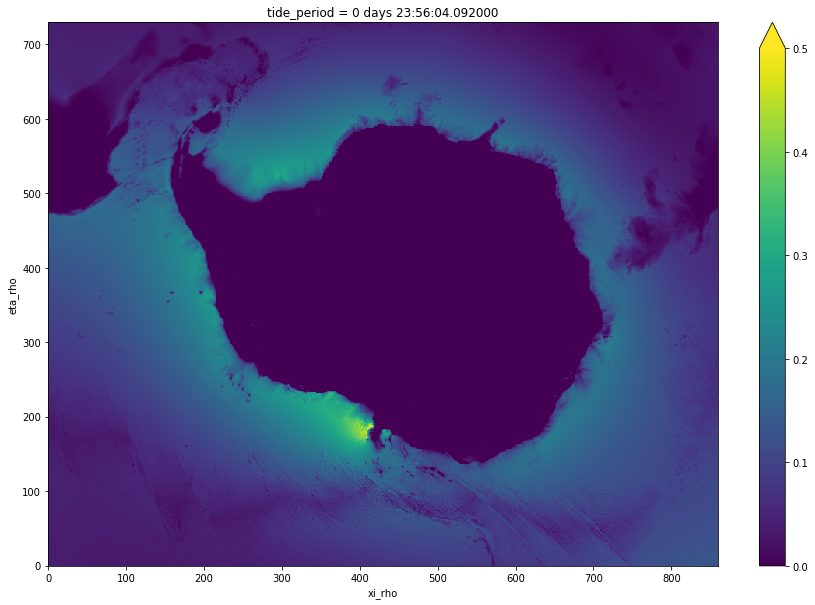

In [80]:
Pamp_tmp = pott_ds.tide_Pamp.where((grid_ds.h > 1000),0.0)
Pamp_tmp = Pamp_tmp.where((grid_ds.zice==0.0),0.0)
scale = (grid_ds.h - 1000)/3000
Pamp_masked = Pamp_tmp.where((grid_ds.h < 1000 )|(grid_ds.h > 4000),Pamp_tmp*scale)
plt.close()
Pamp_masked[4].plot(vmax=0.5,size=10)
plt.show()

### Results

In [24]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_tm_shelf_0006.nc')
ds_tm_shelf = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_tm_shelf_ampl_max = ds_tm_shelf.zeta[336:].max('ocean_time')-ds_tm_shelf.zeta[336:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


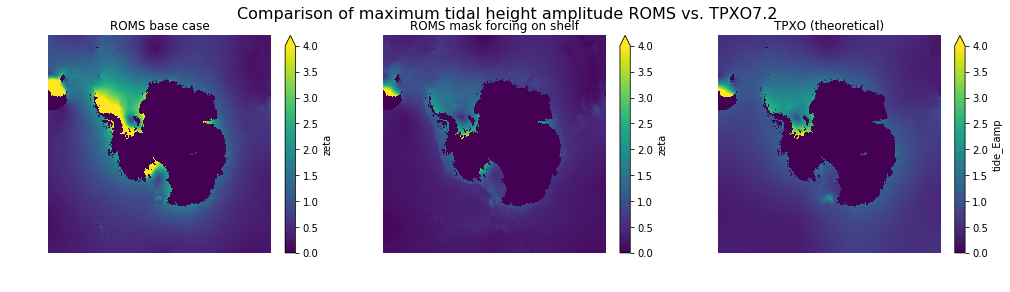

In [25]:
plot_max_ampl(roms_tm_shelf_ampl_max,'mask forcing on shelf')

... Just a bit smoother transition between forcing and no forcing.
### Smoothing the mask edge

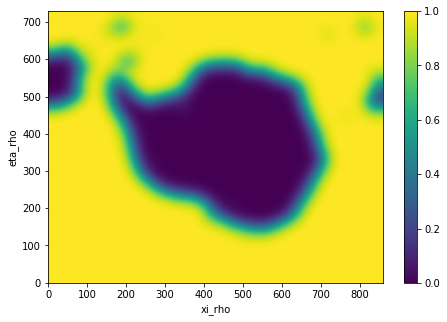

In [26]:
from scipy.ndimage.filters import gaussian_filter, uniform_filter
pott_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','Data','waom10','waom10_ptds_large.nc')
pott_ds = xr.open_dataset(pott_path)
grid_path =  os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','Data','waom10','waom10_grd_large.nc')
grid_ds = xr.open_dataset(grid_path)

mask_tmp = grid_ds.mask_rho.where((grid_ds.zice == 0),0.0)
mask_tmp = mask_tmp.where(grid_ds.h > 1000,0.0)
mask_tmp.values = gaussian_filter(mask_tmp,20)

plt.close()
mask_tmp.plot(size=5)
plt.show()

### Results

In [6]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_tm_smooth_0006.nc')
ds_tm_smooth = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_tm_smooth_ampl_max = ds_tm_smooth.zeta[336:].max('ocean_time')-ds_tm_smooth.zeta[336:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


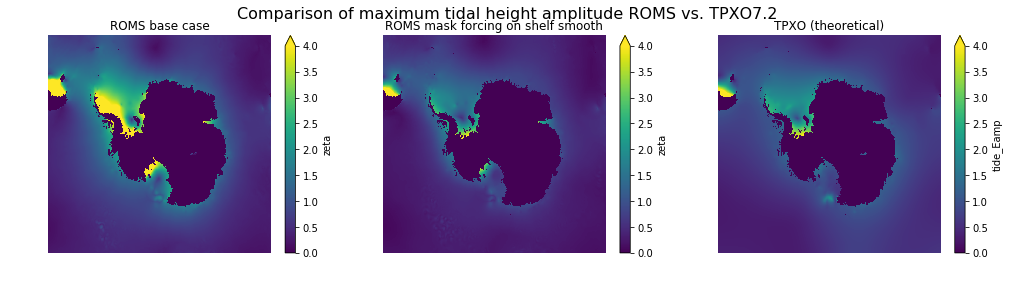

In [33]:
plot_max_ampl(roms_tm_smooth_ampl_max,'mask forcing on shelf smooth')

In [7]:
ds_tm_smooth = O1_M2_ampl(ds_tm_smooth,ds_tm_smooth,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


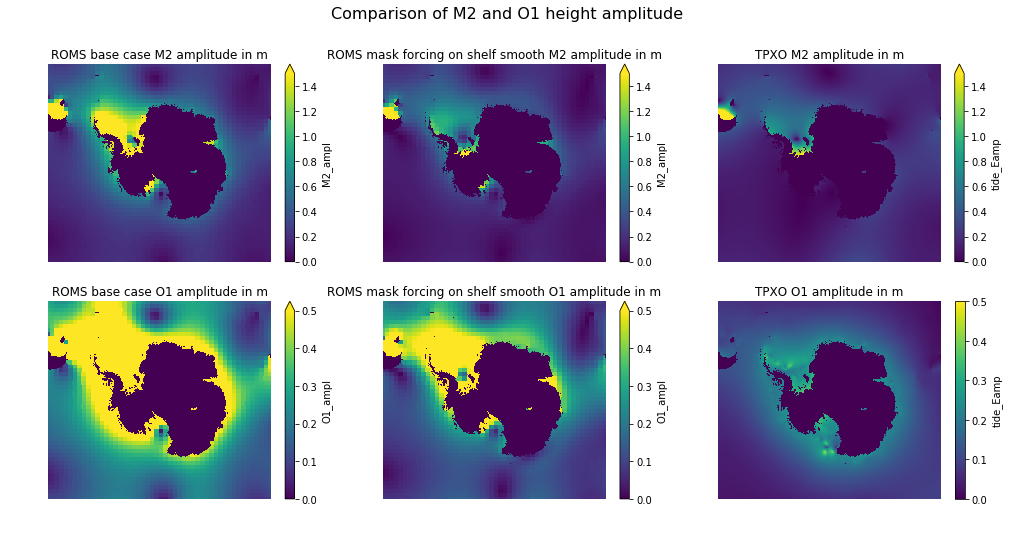

In [34]:
plot_M2O1(ds_tm_smooth,'mask forcing on shelf smooth')

Max amplitude comparison looks good. M2 looks good, but O1 is as expected from 65S case way to big. Sp maybe differnt masks for each constituents? Maybe giving SSH forcing another try?

# SSH forcing at the northern boundary alone

In [14]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_SSH','ocean_his_0006.nc')
ds_SSH = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
#roms_SSH_ampl_max = ds_SSH.zeta[336:].max('ocean_time')-ds_SSH.zeta[336:].mean('ocean_time')

In [56]:
def plot_max_ampl(case_max_ampl_da,case_str,ref_max_ampl,ref_str):
    plt.clf()
    fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(17,4))
    fig.suptitle('Comparison of maximum tidal height amplitude ROMS vs. TPXO7.2',fontsize=16)
    ref_max_ampl.fillna(0).plot(ax=ax1,vmax=4)
    ax1.set_title(ref_str+' [m]')
    ax1.axis('off')
    
    case_max_ampl_da.fillna(0).plot(ax=ax2,vmax=4)
    ax2.set_title(case_str+ ' [m]')
    ax2.axis('off')
    tpxo_ampl_max.tide_Eamp.plot(ax=ax3,vmax=4)
    ax3.set_title('TPXO (theoretical)')
    ax3.axis('off')
    plt.show()

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


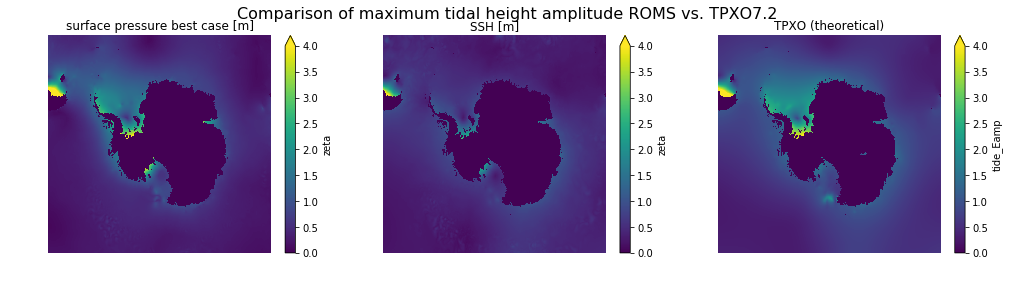

In [57]:
plot_max_ampl(roms_SSH_ampl_max,'SSH',roms_tm_smooth_ampl_max,'surface pressure best case')

In [15]:
ds_SSH = O1_M2_ampl(ds_SSH,ds_SSH,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


In [17]:
# load tpxo forcing amplitude and phase information as Xarray dataset
def plot_M2O1(case_ds,case_str,ds_ref,ref_str):
    plt.close('all')
    fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(17,8))
    ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()
    fig.suptitle('Comparison of M2 and O1 height amplitude',fontsize=16)

    ds_ref.M2_ampl.fillna(0).plot(ax=ax1,vmax=1.5)
    ax1.set_title(ref_str+' [m]')
    ax1.axis('off')

    case_ds.M2_ampl.fillna(0).plot(ax=ax2,vmax=1.5)
    ax2.set_title(case_str +' [m]')
    ax2.axis('off')

    dsf.tide_Eamp[0].plot(ax=ax3,vmax=1.5)
    ax3.set_title('TPXO M2 amplitude in m')
    ax3.axis('off')


    ds_ref.O1_ampl.fillna(0).plot(ax=ax4,vmax=1.5)
    ax4.set_title(ref_str+' [m]')
    ax4.axis('off')

    case_ds.O1_ampl.fillna(0).plot(ax=ax5,vmax=1.5)
    ax5.set_title(case_str+' [m]')
    ax5.axis('off')

    dsf.tide_Eamp[5].plot(ax=ax6,vmax=1.5)
    ax6.set_title('TPXO O1 amplitude in m')
    ax6.axis('off')

    plt.show()

# UV forcing at the northern boundary alone

In [12]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_UV','ocean_his_0002.nc')
ds_UV = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
#roms_UV_ampl_max = ds_UV.zeta[336:].max('ocean_time')-ds_UV.zeta[336:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


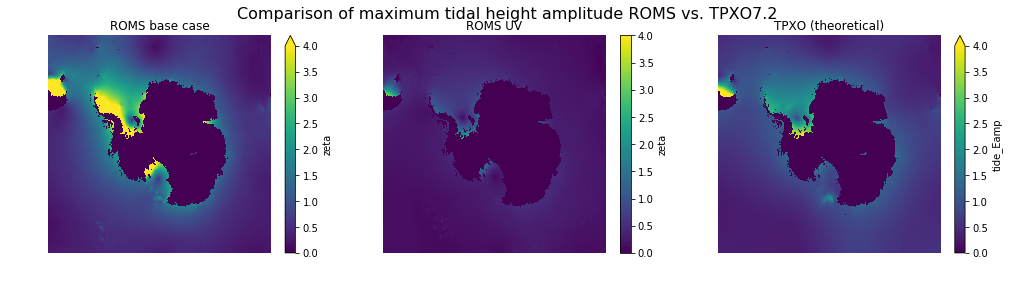

In [15]:
plot_max_ampl(roms_UV_ampl_max,'UV',roms_tm_smooth_ampl_max,'surface pressure best case')

In [13]:
ds_UV = O1_M2_ampl(ds_UV,ds_UV,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


# SSH and UV forcing at the northern boundary alone

In [10]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_SSHUV','ocean_his_0002.nc')
ds_SSHUV = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
#roms_SSHUV_ampl_max = ds_SSHUV.zeta[336:].max('ocean_time')-ds_SSHUV.zeta[336:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


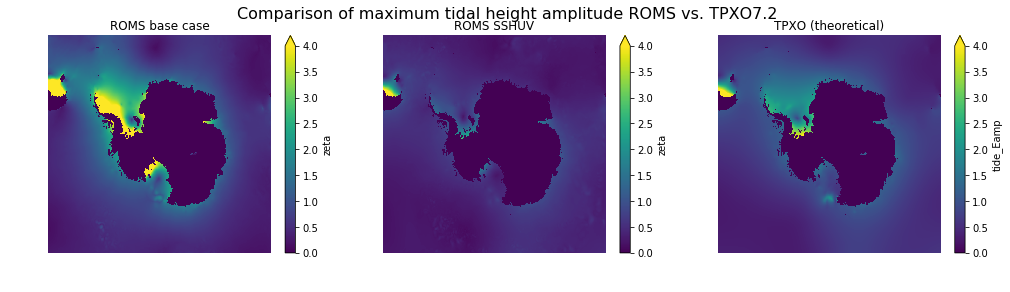

In [20]:
plot_max_ampl(roms_SSHUV_ampl_max,'SSHUV',roms_tm_smooth_ampl_max,'surface pressure best case')

In [11]:
ds_SSHUV = O1_M2_ampl(ds_SSHUV,ds_SSHUV,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


# SSH, UV  and POT forcing

In [8]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_SSHUVPOT','ocean_his_0002.nc')
ds_SSHUVPOT = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
#roms_SSHUVPOT_ampl_max = ds_SSHUVPOT.zeta[336:].max('ocean_time')-ds_SSHUVPOT.zeta[336:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


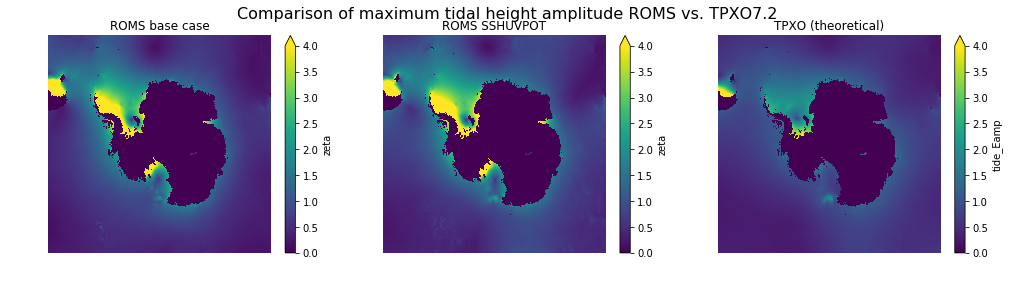

In [30]:
plot_max_ampl(roms_SSHUVPOT_ampl_max,'SSHUVPOT',roms_tm_smooth_ampl_max,'surface pressure best case')

In [9]:
ds_SSHUVPOT = O1_M2_ampl(ds_SSHUVPOT,ds_SSHUVPOT,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


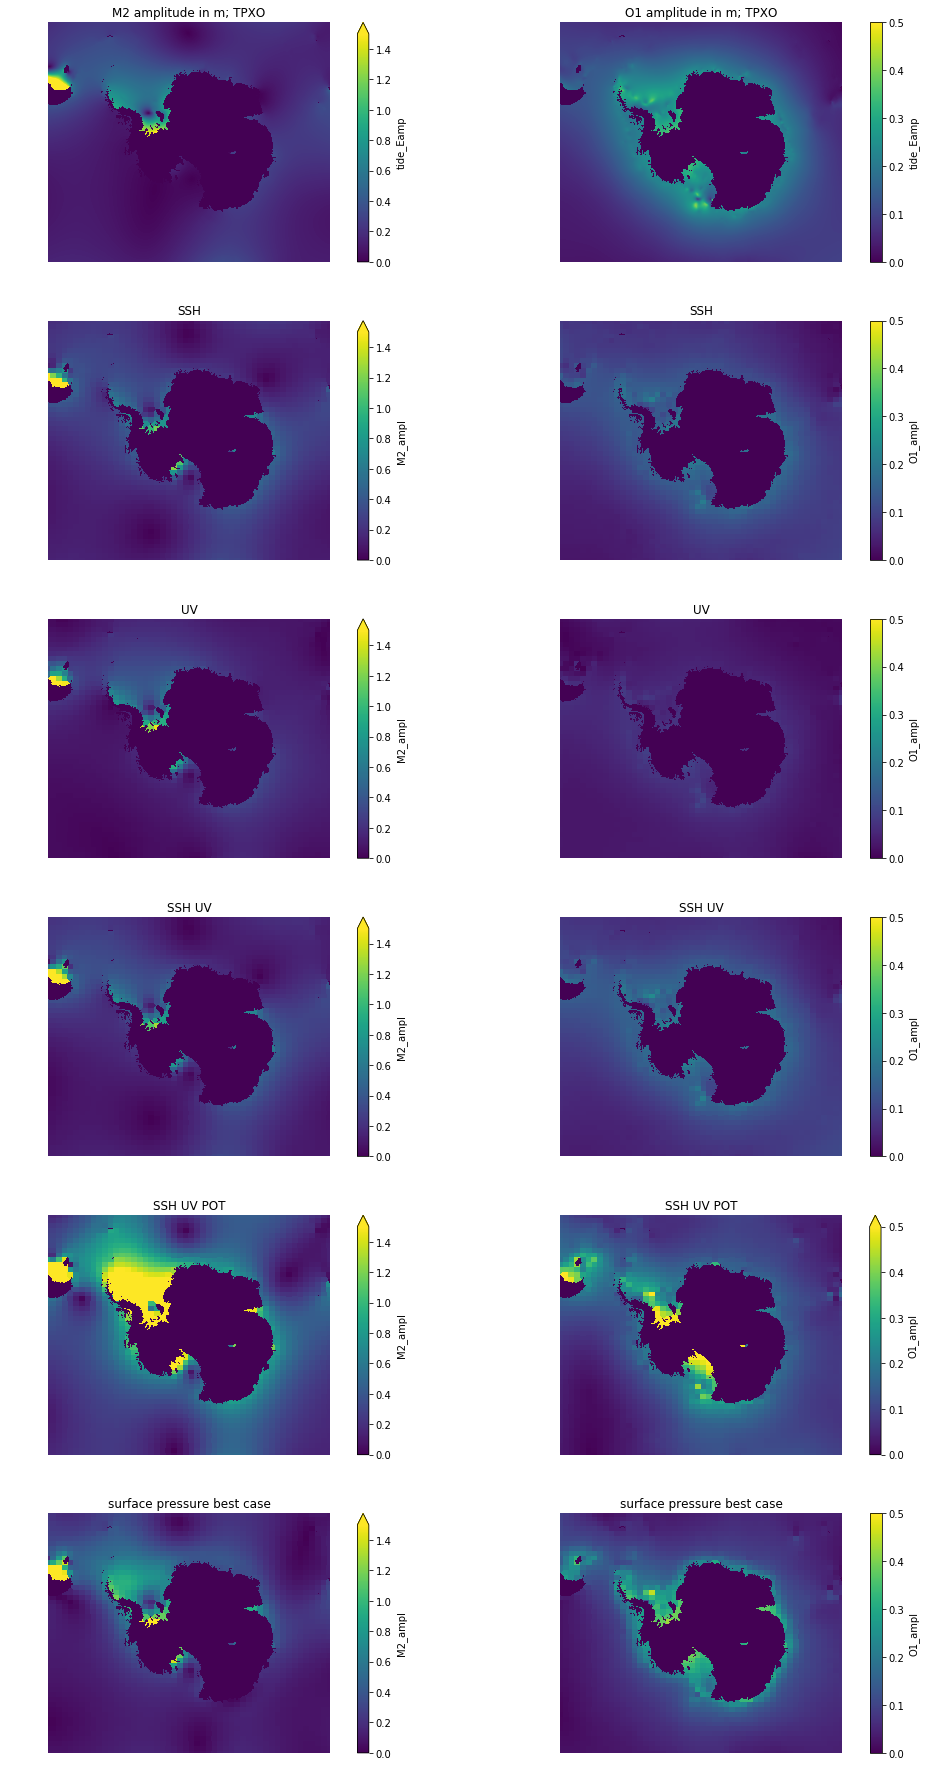

In [16]:
plt.close('all')
fig,axes = plt.subplots(ncols=2,nrows=6,figsize=(15,25))
#fig.suptitle('Comparison of M2 and O1 height amplitude',fontsize=16)

dsf.tide_Eamp[0].plot(ax=axes[0,0],vmax=1.5)
axes[0,0].set_title('M2 amplitude in m; TPXO')

dsf.tide_Eamp[5].plot(ax=axes[0,1],vmax=0.5)
axes[0,1].set_title('O1 amplitude in m; TPXO')

def compare_M2_O1(ds,case_str,ax):
    ds.M2_ampl.fillna(0).plot(ax=ax[0],vmax=1.5)
    ax[0].set_title(case_str)

    ds.O1_ampl.fillna(0).plot(ax=ax[1],vmax=0.5)
    ax[1].set_title(case_str)

compare_M2_O1(ds_SSH,'SSH',axes[1])

compare_M2_O1(ds_UV,'UV',axes[2])

compare_M2_O1(ds_SSHUV,'SSH UV',axes[3])

compare_M2_O1(ds_SSHUVPOT,'SSH UV POT',axes[4])

compare_M2_O1(ds_tm_smooth,"surface pressure best case",axes[5])

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')

plt.tight_layout()

plt.show()

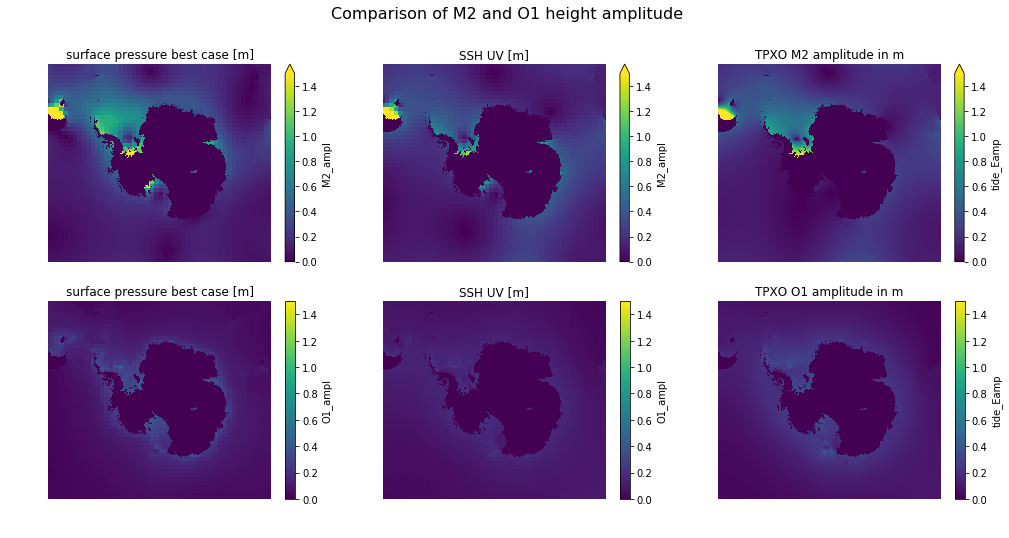

In [18]:
plot_M2O1(ds_SSHUV,'SSH UV',ds_tm_smooth,'surface pressure best case')